In [1]:
!pip3 install pydicom
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydicom as dcm
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import gc

     |████████████████████████████████| 2.0 MB 13.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_csv(file_path):
  content = pd.read_csv(file_path)
  return content

project_path = '/content/drive/MyDrive/Great Learning/rsna-pneumonia-detection-challenge'
label_data = read_csv("/".join((project_path, 'stage_2_train_labels.csv')))
class_info = read_csv("/".join((project_path, 'stage_2_detailed_class_info.csv')))


In [4]:
label_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [5]:
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [6]:
def merge_data_frames(left_df,right_df,merge_on):
  df = pd.merge(left = left_df, right = right_df, how = 'left', on = merge_on)
  df = df.drop_duplicates()
  df.info()

merge_data_frames(class_info,label_data,'patientId')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


**Database table Preprocessing**

In [7]:
def check_for_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)   # finding total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) #percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # putting the above two together
    return missing_data


In [8]:
check_for_missing_data(label_data)

,Total,Percent
height,20672,0.683892
width,20672,0.683892
y,20672,0.683892
x,20672,0.683892
Target,0,0.000000
patientId,0,0.000000


In [9]:
check_for_missing_data(class_info)

,Total,Percent
class,0,0.0
patientId,0,0.0


Observation : No missing value found in the class_info table. All the target values are filled therefore there is no empty value, cell with Nan or empty cell in label_data are having no phenumonia so let's replace those value with 

In [10]:
label_data.fillna(0, inplace=True)

In [11]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [12]:
label_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [13]:
label_data[label_data["Target"]==1].describe().T

,count,mean,std,min,25%,50%,75%,max
x,9555.0,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,366.839560,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,9555.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [14]:
np.unique(class_info["class"])  

array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
      dtype=object)

There are 3 classes - 


1.   Lung Opacity
2.   No Lung Opacity / Not Normal
3.   Normal



In [15]:
class_info[class_info["patientId"]=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal


In [16]:
label_data[label_data['patientId']=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0


No Lung Opacity / Not Normal has been classified as Target 0

In [17]:
class_info[class_info["patientId"]=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']


,patientId,class
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal


In [18]:
label_data[label_data['patientId']=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

,patientId,x,y,width,height,Target
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0


Normal has been classified as 0 as well

In [19]:
class_info[class_info["patientId"]=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,class
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [20]:
label_data[label_data['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Lung Opacity has been classified as 1 

In [21]:
# Images Example
train_images_dir = "/".join((project_path, "stage_2_train_images/"))
test_images_dir = "/".join((project_path, "stage_2_test_images/"))

#print(os.listdir(train_images_dir))

def parse_dicom_images(image_dir):
  images_list = []
  images = os.listdir(image_dir)
  for image in images:
    image_file = os.path.join(image_dir, image)
    if os.path.isfile(image_file):
      images_list.append(image_file)
  return images_list

In [24]:
train_images = parse_dicom_images(train_images_dir)
test_images = parse_dicom_images(test_images_dir)
print('5 Training images', train_images[:5])
print('5 Test images', test_images[:5])

5 Training images ['/content/drive/MyDrive/Great Learning/rsna-pneumonia-detection-challenge/stage_2_train_images/f7aaf2ce-cceb-49f8-b62d-fe2a31665718.dcm', '/content/drive/MyDrive/Great Learning/rsna-pneumonia-detection-challenge/stage_2_train_images/f6a05a24-1cd8-4eb1-ad7c-5d5fd5d885be.dcm', '/content/drive/MyDrive/Great Learning/rsna-pneumonia-detection-challenge/stage_2_train_images/f70fe0f0-7fbc-4614-9305-4861196b1143.dcm', '/content/drive/MyDrive/Great Learning/rsna-pneumonia-detection-challenge/stage_2_train_images/f741a9b1-f5d5-4160-bf27-bf8dbc94cf50.dcm', '/content/drive/MyDrive/Great Learning/rsna-pneumonia-detection-challenge/stage_2_train_images/f7379744-be39-44b2-8816-a743857bd6a6.dcm']
5 Test images []


In [25]:
column_list = ["Patient ID", "Patient Sex", "Patient's Age", "View Position", "Image Size"]
file_meta_Data = pd.DataFrame(columns=column_list)

def add_images_to_df(df,images_list,count_limit=100):
    data = []
    count = 0
    for image_path in images_list:
      data_row_img_data = dcm.read_file(image_path)
      values = []
      count = count + 1
      values.append(data_row_img_data.PatientID)
      values.append(data_row_img_data.PatientSex)
      values.append(data_row_img_data.PatientAge)
      values.append(data_row_img_data.ViewPosition)
      values.append(f"{data_row_img_data.Rows}x{data_row_img_data.Columns}")
      zipped_val = dict(zip(column_list, values))
      df = df.append(zipped_val, True)
      print(count)
      if count >=count_limit:
        break
    print(df)
    return df

In [26]:
file_meta_Data = add_images_to_df(file_meta_Data, train_images,1000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [27]:
file_meta_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Patient ID     1000 non-null   object
 1   Patient Sex    1000 non-null   object
 2   Patient's Age  1000 non-null   object
 3   View Position  1000 non-null   object
 4   Image Size     1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [28]:
dicom_file_path = os.path.join(train_images_dir + "/" + "05eebe4c-bca2-40d4-bb20-54fc60e2bcea.dcm")
file = dcm.read_file(dicom_file_path)
file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.15214.1517874384.336739
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.15214.1517874384.336739
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Data Visualisation

In [29]:
gc.collect()

204

In [30]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patient_img = data_row['patientId']+'.dcm'
        image_path = f"{train_images_dir}/{patient_img}"
        data_row_img_data = dcm.read_file(image_path)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(image_path)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        rows = label_data[label_data['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="red",alpha = 0.1))   
    plt.show()


<class 'pandas.core.frame.DataFrame'>
                               patientId      x      y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1


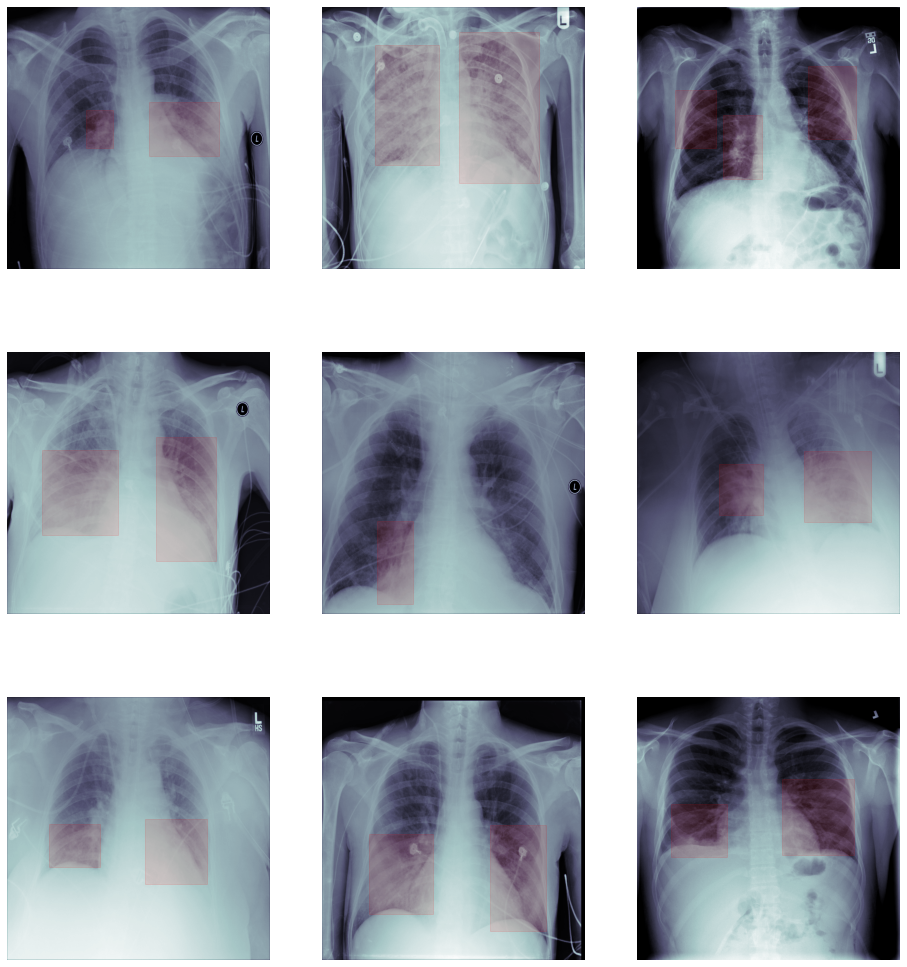

In [48]:
target = label_data[label_data['Target']==1]
print(type(target))
print(target.head())
#generating 9 row
show_dicom_images_with_boxes(label_data[label_data['Target']==1].sample(9))

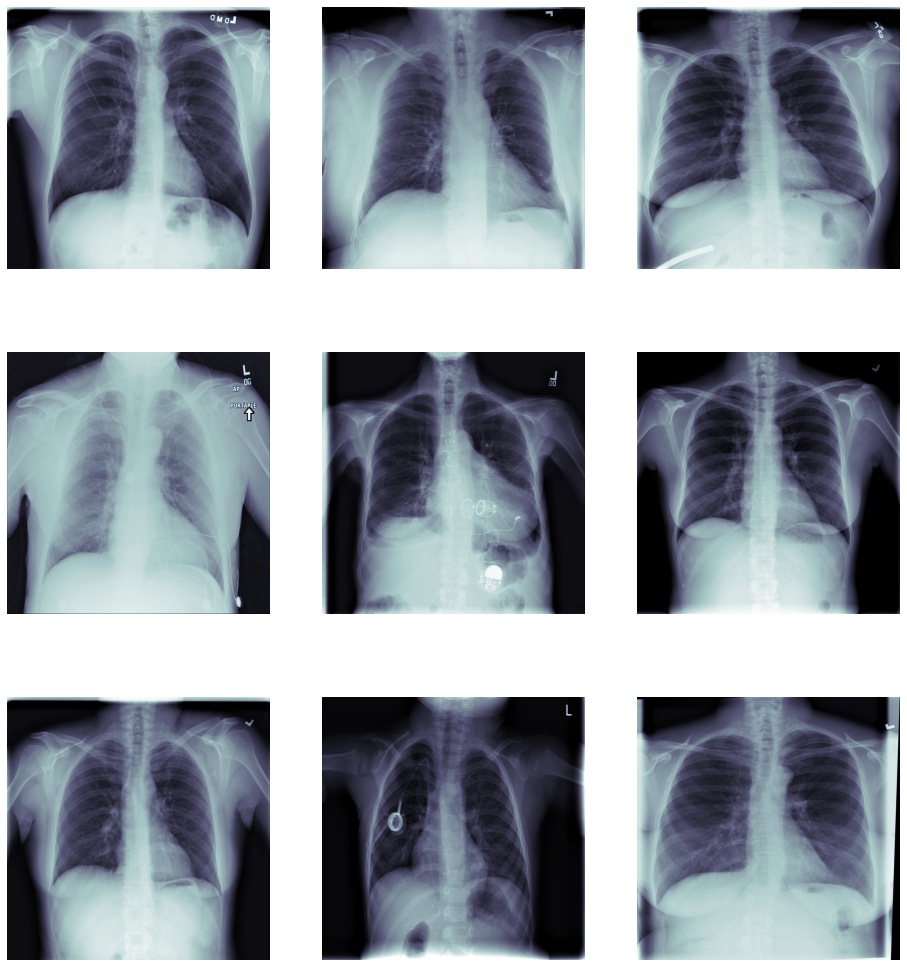

In [38]:
show_dicom_images_with_boxes(label_data[label_data['Target']==0].sample(9))

In [ ]:
fig=plt.figure(figsize=(15,15))
columns=5
rows=5
for i in range(1, columns*rows+1):
  for items in patientId.iteritems():
    dcm_file = project_path + '/stage_2_train_images/%s.dcm' % items[1]
    if os.path.exists(dcm_file):
      dcm_data = pydicom.read_file(dcm_file)
      im = dcm_data.pixel_array
      fig.add_subplot(rows,columns,i)
      plt.imshow(im,cmap=pylab.cm.gist_gray)
      #pylab.axis('off')


In [ ]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

In [ ]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')